In [1]:
# !pip install torch==2.1.2 torchvision==0.16.2 torchaudio==2.1.2 --extra-index-url https://download.pytorch.org/whl/cu121
# !pip install transformers datasets pytorch-crf scikit-learn seqeval matplotlib

In [2]:
!python --version

Python 3.10.16


### Data loading

In [3]:
def read_ner_file(path):
    sentences = []
    labels = []
    words = []
    tags = []

    with open(path, encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                if words:
                    sentences.append(words)
                    labels.append(tags)
                    words, tags = [], []
            else:
                splits = line.split()
                if len(splits) >= 2:
                    word, tag = splits[0], splits[-1]
                    words.append(word)
                    tags.append(tag)
    if words:
        sentences.append(words)
        labels.append(tags)
    return sentences, labels

# data
train_sentences, train_labels = read_ner_file("train.txt")
valid_sentences, valid_labels = read_ner_file("valid.txt")
test_sentences, test_labels = read_ner_file("test.txt")  

print("train 句子數量:", len(train_sentences))
print("valid 句子數量:", len(valid_sentences))
print("testing 句子數量:", len(test_sentences))


train 句子數量: 5251
valid 句子數量: 662
testing 句子數量: 664


In [4]:
# label dictionary
unique_tags = sorted(set(tag for sent in train_labels for tag in sent))
label2id = {tag: idx for idx, tag in enumerate(unique_tags)}
id2label = {idx: tag for tag, idx in label2id.items()}

print("all labels：", label2id)


all labels： {'B-Area': 0, 'B-Exp': 1, 'B-Features': 2, 'B-HackOrg': 3, 'B-Idus': 4, 'B-OffAct': 5, 'B-Org': 6, 'B-Purp': 7, 'B-SamFile': 8, 'B-SecTeam': 9, 'B-Time': 10, 'B-Tool': 11, 'B-Way': 12, 'I-Area': 13, 'I-Exp': 14, 'I-Features': 15, 'I-HackOrg': 16, 'I-Idus': 17, 'I-OffAct': 18, 'I-Org': 19, 'I-Purp': 20, 'I-SamFile': 21, 'I-SecTeam': 22, 'I-Time': 23, 'I-Tool': 24, 'I-Way': 25, 'O': 26}


###  Tokenizer

In [5]:
from transformers import AutoModel, BertTokenizerFast

tokenizer = BertTokenizerFast.from_pretrained("jackaduma/SecBERT")

bert_model = AutoModel.from_pretrained("jackaduma/SecBERT")


c:\Users\user\Miniconda3\envs\hw3-gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm

A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.5 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "c:\Users\user\Miniconda3\envs\hw3-gpu\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\user\Miniconda3\envs\hw3-gpu\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c:\User

In [6]:
# from transformers import AutoTokenizer, AutoModel

# # ✅ 使用官方 BERT-base 模型（架構完全一致）
# tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
# bert_model = AutoModel.from_pretrained("bert-base-uncased").to("cuda")

In [7]:
from collections import defaultdict

def organize_encodings(list_of_dicts):
    batch = defaultdict(list)
    for d in list_of_dicts:
        for k, v in d.items():
            batch[k].append(v)
    return dict(batch)

def tokenize_and_align_labels(sentences, labels, label2id, tokenizer):
    tokenized_inputs = []

    for words, word_labels in zip(sentences, labels):
        encoding = tokenizer(words,
                             is_split_into_words=True,
                             return_offsets_mapping=True,
                             padding='max_length',
                             truncation=True,
                             max_length=128)

        word_ids = encoding.word_ids()
        encoding['word_ids'] = word_ids

        label_ids = []
        previous_word_idx = None
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(label2id[word_labels[word_idx]])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx

        encoding['labels'] = label_ids
        tokenized_inputs.append(encoding)

    return tokenized_inputs



In [8]:
train_encodings = tokenize_and_align_labels(train_sentences, train_labels, label2id, tokenizer)
valid_encodings = tokenize_and_align_labels(valid_sentences, valid_labels, label2id, tokenizer)
test_encodings  = tokenize_and_align_labels(test_sentences,  test_labels,  label2id, tokenizer)

### Dataset

In [ ]:
from torch.utils.data.dataloader import default_collate

from torch.utils.data import Dataset
import torch

def custom_collate_fn(batch):
    batch = [b for b in batch if b is not None]
    word_ids = [b.pop("word_ids") for b in batch]
    collated_batch = default_collate(batch)
    collated_batch["word_ids"] = word_ids
    return collated_batch

class NERDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __len__(self):
        return len(self.encodings)

    def __getitem__(self, idx):
        data = self.encodings[idx]

        if "input_ids" not in data or "attention_mask" not in data or "labels" not in data:
            return None

        item = {
            "input_ids": torch.tensor(data["input_ids"], dtype=torch.long),
            "attention_mask": torch.tensor(data["attention_mask"], dtype=torch.long),
            "labels": torch.tensor(data["labels"], dtype=torch.long),
        }
        if "word_ids" in data:
            item["word_ids"] = data["word_ids"]
        return item


In [ ]:
for i, e in enumerate(train_encodings):
    if not all(k in e for k in ("input_ids", "attention_mask", "labels")):
        print(f"❌ Bad sample at index {i}: keys = {e.keys()}")

In [11]:
train_dataset = NERDataset(train_encodings)
valid_dataset = NERDataset(valid_encodings)
test_dataset  = NERDataset(test_encodings)

### Model

In [12]:
import torch
import torch.nn as nn
from torchcrf import CRF

class SecBERT_BiLSTM_CRF(nn.Module):
    def __init__(self, bert_model, hidden_dim, num_labels):
        super(SecBERT_BiLSTM_CRF, self).__init__()
        self.bert = bert_model
        self.lstm = nn.LSTM(input_size=bert_model.config.hidden_size, hidden_size=hidden_dim, batch_first=True, bidirectional=True)
        self.hidden2tag = nn.Linear(hidden_dim * 2, num_labels)
        self.crf = CRF(num_labels, batch_first=True)

    def forward(self, input_ids, attention_mask, labels=None):
        with torch.no_grad():
            outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
            embeddings = outputs.last_hidden_state

        lstm_out, _ = self.lstm(embeddings)
        emissions = self.hidden2tag(lstm_out)

        if labels is not None:
            labels = labels.clone()
            labels[labels == -100] = 0
            loss = -self.crf(emissions, labels, mask=attention_mask.bool(), reduction='mean')
            return loss
        else:
            return self.crf.decode(emissions, mask=attention_mask.bool())


In [13]:
num_labels = len(label2id)
device = torch.device("cuda")
model = SecBERT_BiLSTM_CRF(bert_model=bert_model, hidden_dim=256, num_labels=num_labels).to(device)

## Dataloader

In [14]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=custom_collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=8, collate_fn=custom_collate_fn)
test_loader  = DataLoader(test_dataset,  batch_size=8, collate_fn=custom_collate_fn)


In [15]:
for i in range(3):  # 看前三筆
    words = train_sentences[i]
    labels = train_labels[i]
    encoding = tokenizer(words,
                         is_split_into_words=True,
                         return_offsets_mapping=True,
                         truncation=True,
                         padding='max_length',
                         max_length=128)

    tokens = tokenizer.convert_ids_to_tokens(encoding["input_ids"])
    word_ids = encoding.word_ids()

    print(f"\n Sentence {i}: {' '.join(words)}")
    print(f" Tokens: {tokens}")
    print(f" Word IDs: {word_ids}")
    print(f" Labels: {labels}")



 Sentence 0: The admin@338 has largely targeted organizations involved in financial , economic and trade policy , typically using publicly available RATs such as Poison Ivy , as well some non-public backdoors .
 Tokens: ['[CLS]', 'the', 'admin', '@', '338', 'has', 'largely', 'targeted', 'organizations', 'involved', 'in', 'financial', ',', 'economic', 'and', 'trade', 'policy', ',', 'typically', 'using', 'publicly', 'available', 'rats', 'such', 'as', 'poison', 'ivy', ',', 'as', 'well', 'some', 'non', '-', 'public', 'backdoors', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[P

In [ ]:
import torch.optim as optim
from seqeval.metrics import classification_report, precision_score, recall_score, f1_score
from torch.optim.lr_scheduler import ReduceLROnPlateau


optimizer = optim.Adam(model.parameters(), lr=5e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)
epochs = 50

def evaluate(model, data_loader, id2label, sentences, device, show_debug=False):
    model.eval()
    predictions, true_labels = [], []
    total_loss = 0 

    with torch.no_grad():
        for batch_idx, batch in enumerate(data_loader):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            
            loss = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            total_loss += loss.item()


            preds = model(input_ids=input_ids, attention_mask=attention_mask)

            for i in range(len(preds)):
                word_ids = batch["word_ids"][i]
                pred_tags, true_tags = [], []
                previous_word_idx = None

                for j, word_idx in enumerate(word_ids):
                    if word_idx is None or word_idx == previous_word_idx:
                        continue
                    pred_label = id2label[preds[i][j]]
                    true_label = id2label[labels[i][j].item()] if labels[i][j].item() != -100 else 'O'
                    pred_tags.append(pred_label)
                    true_tags.append(true_label)
                    previous_word_idx = word_idx

                predictions.append(pred_tags)
                true_labels.append(true_tags)

                if show_debug and batch_idx < 1 and i < 1:
                    print("\n Debug Sentence Preview")
                    print(" Original Sentance：", sentences[batch_idx * data_loader.batch_size + i])
                    print(" True labels：", true_tags)
                    print(" Pred labels：", pred_tags)
                    print(" Word-by-word Compare：")
                    for w, t, p in zip(sentences[batch_idx * data_loader.batch_size + i], true_tags, pred_tags):
                        print(f"{w:15} → GT: {t:12} | Pred: {p}")
    
    avg_loss = total_loss / len(data_loader)
    print("\n Classification Report:\n")
    print(classification_report(true_labels, predictions))

    return precision_score(true_labels, predictions), recall_score(true_labels, predictions), f1_score(true_labels, predictions), avg_loss, true_labels, predictions

In [17]:
import matplotlib.pyplot as plt

# Early Stopping 
best_f1 = 0
patience = 3
patience_counter = 0

train_losses = []
val_f1s = []
val_losses = []

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()
        loss = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"\n[Epoch {epoch+1}] Loss: {total_loss:.4f}")
    p, r, f, val_loss, true_labels, predictions = evaluate(model, valid_loader, id2label, valid_sentences, device, show_debug=False)
    print(f"Validation — P: {p:.4f} | R: {r:.4f} | F1: {f:.4f} | Loss: {val_loss:.4f}")

    train_losses.append(total_loss)
    val_f1s.append(f)
    val_losses.append(val_loss)
   
    scheduler.step(f)
   
    if f > best_f1:
        best_f1 = f
        patience_counter = 0
        torch.save(model.state_dict(), "best_model_9.pt")
        print("F1 improved, model saved.")
    else:
        patience_counter += 1
        print(f"No improvement. Patience: {patience_counter}/{patience}")

    if patience_counter >= patience:
        print("Early stopping triggered.")
        break



[Epoch 1] Loss: 25090.8753

 Classification Report:

              precision    recall  f1-score   support

        Area       0.08      0.31      0.12       144
         Exp       1.00      0.35      0.52       131
    Features       0.00      0.00      0.00        97
     HackOrg       0.36      0.03      0.05       426
        Idus       0.50      0.03      0.06       103
      OffAct       0.00      0.00      0.00       100
         Org       0.00      0.00      0.00       112
        Purp       0.00      0.00      0.00        82
     SamFile       0.00      0.00      0.00       191
     SecTeam       0.00      0.00      0.00       178
        Time       0.08      0.01      0.01       183
        Tool       0.00      0.00      0.00       317
         Way       0.00      0.00      0.00       109

   micro avg       0.16      0.05      0.07      2173
   macro avg       0.16      0.06      0.06      2173
weighted avg       0.17      0.05      0.05      2173

Validation — P: 0.1569 | 

c:\Users\user\Miniconda3\envs\hw3-gpu\lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 improved, model saved.

[Epoch 2] Loss: 14006.5495

 Classification Report:

              precision    recall  f1-score   support

        Area       0.12      0.52      0.20       144
         Exp       0.78      0.69      0.73       131
    Features       0.50      0.05      0.09        97
     HackOrg       0.40      0.33      0.36       426
        Idus       0.44      0.36      0.39       103
      OffAct       0.15      0.02      0.04       100
         Org       0.06      0.01      0.02       112
        Purp       0.20      0.01      0.02        82
     SamFile       0.25      0.01      0.01       191
     SecTeam       0.58      0.38      0.46       178
        Time       0.74      0.69      0.71       183
        Tool       0.19      0.04      0.07       317
         Way       0.36      0.08      0.13       109

   micro avg       0.36      0.26      0.30      2173
   macro avg       0.37      0.25      0.25      2173
weighted avg       0.37      0.26      0.27      2173


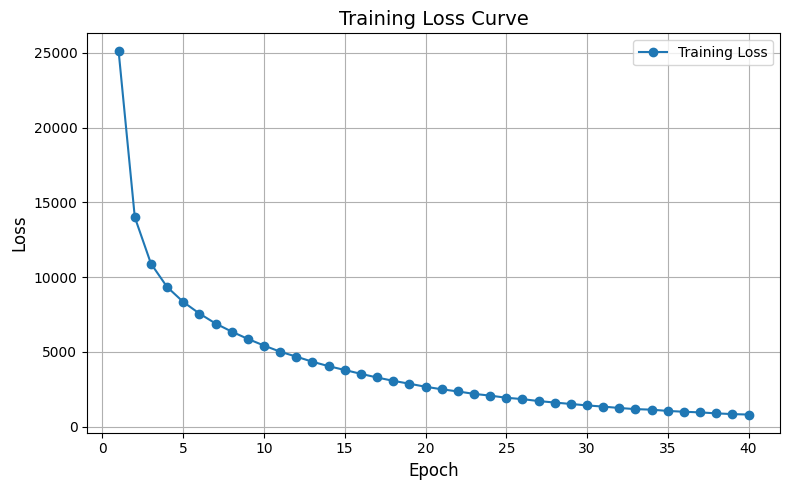

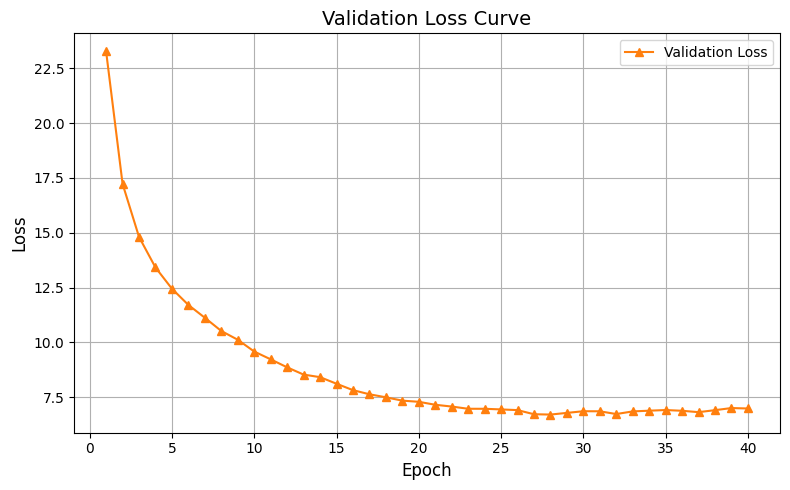

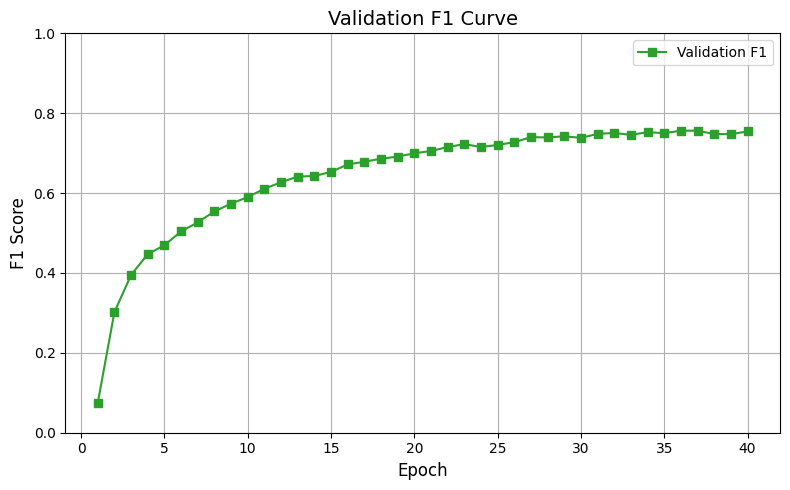

In [19]:
import matplotlib.pyplot as plt
epochs = len(train_losses)
plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs + 1), train_losses, label="Training Loss", marker='o', color='tab:blue')
plt.title("Training Loss Curve", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs + 1), val_losses, label="Validation Loss", marker='^', color='tab:orange')
plt.title("Validation Loss Curve", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs + 1), val_f1s, label="Validation F1", marker='s', color='tab:green')
plt.title("Validation F1 Curve", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("F1 Score", fontsize=12)
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Testing

In [ ]:
# Final Test Evaluation
print("\n Final Evaluation on Test Set:")
p_test, r_test, f1_test,loss, true_labels_test, pred_labels_test = evaluate(model, test_loader, id2label, test_sentences, device, show_debug=False)
print(f"Test — P: {p_test:.4f} | R: {r_test:.4f} | F1: {f1_test:.4f} | loss: {loss:.4f}") 


 Final Evaluation on Test Set:

 Classification Report:

              precision    recall  f1-score   support

        Area       0.61      0.78      0.69       216
         Exp       0.98      1.00      0.99       132
    Features       0.97      0.99      0.98       116
     HackOrg       0.78      0.78      0.78       369
        Idus       0.87      0.95      0.91       129
      OffAct       0.76      0.77      0.76       150
         Org       0.78      0.61      0.68       137
        Purp       0.84      0.95      0.89       115
     SamFile       0.91      0.89      0.90       248
     SecTeam       0.86      0.82      0.84       152
        Time       0.85      0.91      0.88       169
        Tool       0.74      0.69      0.71       315
         Way       0.90      0.96      0.93       100

   micro avg       0.81      0.83      0.82      2348
   macro avg       0.83      0.85      0.84      2348
weighted avg       0.82      0.83      0.82      2348

Test — P: 0.8131 | R:

In [21]:
def align_label_lengths(true_labels, pred_labels):
    aligned_true = []
    aligned_pred = []
    for t, p in zip(true_labels, pred_labels):
        if len(t) != len(p):
            continue
        aligned_true.append(t)
        aligned_pred.append(p)
    return aligned_true, aligned_pred

aligned_true, aligned_pred = align_label_lengths( true_labels_test,  pred_labels_test)

In [22]:
print(set(sum(true_labels_test, [])))

{'I-SecTeam', 'B-Exp', 'B-Tool', 'I-Exp', 'O', 'B-SamFile', 'I-OffAct', 'B-Area', 'B-Purp', 'I-Purp', 'B-Time', 'I-Area', 'I-SamFile', 'B-Org', 'I-Time', 'I-Tool', 'B-Features', 'I-HackOrg', 'I-Org', 'I-Features', 'B-Idus', 'I-Way', 'B-SecTeam', 'B-HackOrg', 'B-Way', 'I-Idus', 'B-OffAct'}


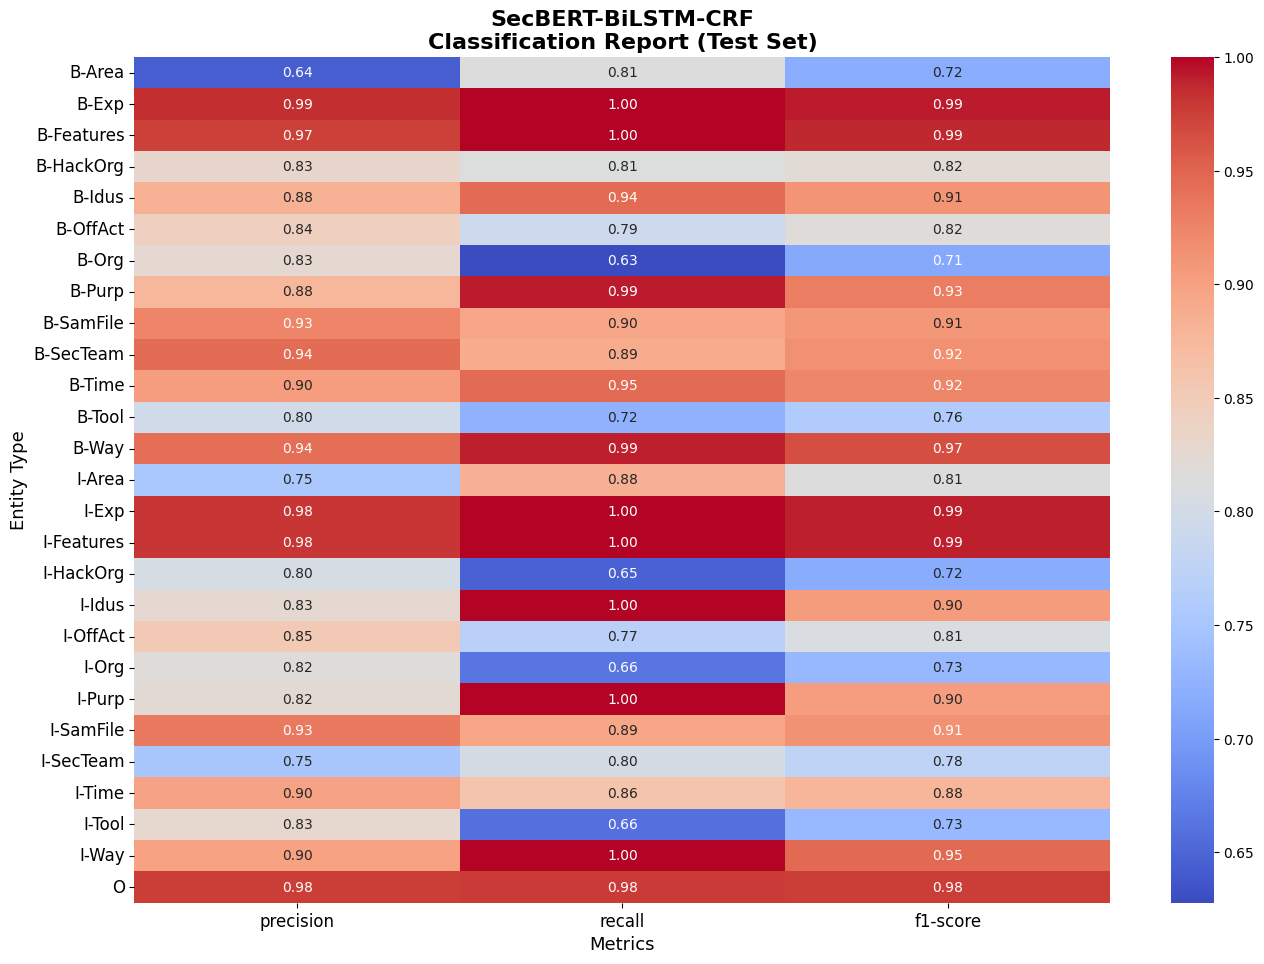

In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support

flat_true = sum(aligned_true, [])
flat_pred = sum(aligned_pred, [])

labels = sorted(list(set(flat_true + flat_pred))) 
p, r, f1, s = precision_recall_fscore_support(flat_true, flat_pred, labels=labels)

df = pd.DataFrame({
    "precision": p,
    "recall": r,
    "f1-score": f1
}, index=labels)

plt.figure(figsize=(14, 10))
sns.heatmap(df, annot=True, cmap="coolwarm", fmt=".2f", cbar=True,
            annot_kws={"fontsize":10})

plt.title("SecBERT-BiLSTM-CRF\nClassification Report (Test Set)", fontsize=16, weight='bold')
plt.xlabel("Metrics", fontsize=13)
plt.ylabel("Entity Type", fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=2)
plt.show()

In [24]:
def save_test_predictions(sentences, predictions, output_path="test_pred_name.txt"):
    with open(output_path, "w", encoding="utf-8") as f:
        for sent, tags in zip(sentences, predictions):
            for word, tag in zip(sent, tags):
                f.write(f"{word} {tag}\n")
            f.write("\n") 
    print(f" Test predictions saved to {output_path}")

In [25]:
save_test_predictions(test_sentences, pred_labels_test, "test_pred_9.txt")

 Test predictions saved to test_pred_9.txt
